In [1]:
import sys
sys.path.append('..')

from my_package.data_cleaning import *
from my_package.modeling import *
from my_package.preprocessing import *
from my_package.nn_modeling import *

In [2]:
def split_data(df,criteria='random'):
    X = df.drop(['fraud_bool'], axis=1)
    y = df['fraud_bool']
    if criteria=='paper':

        # Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
        X_train = X[X['month']<6]
        X_test = X[X['month']>=6]
        y_train = y[X['month']<6]
        y_test = y[X['month']>=6]


    elif criteria=='random':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    elif criteria=='stratify':

        X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42) 

    X_train.drop('month', axis=1, inplace=True)
    X_test.drop('month', axis=1, inplace=True)
    return X_train, X_test, y_train, y_test

- note after reading the data with the data cleaning class the 'device_fraud_count' is deleted as itis constant for all the records.

# working on the Base data 

In [3]:
# reading the base csv file using the custom class
df=data_cleaning('Base.csv')

# reformate the features datatypes
df.data['income']= df.data['income'].astype(float)
df.data['customer_age']= df.data['customer_age'].astype(int)
df.data['email_is_free']=df.data['email_is_free'].astype(int)
df.data['phone_home_valid']=df.data['phone_home_valid'].astype(int)
df.data['phone_mobile_valid']=df.data['phone_mobile_valid'].astype(int)
df.data['has_other_cards']=df.data['has_other_cards'].astype(int)
df.data['foreign_request']=df.data['foreign_request'].astype(int)
df.data['keep_alive_session']=df.data['keep_alive_session'].astype(int)
df.data['source']=df.data['source'].astype('object')
df.data['device_distinct_emails_8w']=df.data['device_distinct_emails_8w'].astype(int)

In [4]:
# replace the -1 values with nulls
df.put_nulls()

prev_address_months_count 712920
current_address_months_count 4254
credit_risk_score 488
bank_months_count 253635
session_length_in_minutes 2015
device_distinct_emails_8w 359


fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           712920
current_address_months_count          4254
customer_age                             0
days_since_request                       0
intended_balcon_amount                   0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                      488
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   253635
has_other_cards                          0
proposed_cr

In [6]:
# handling the intended balcon 
# replace negative values with np.nan in column 'A'
df.data['intended_balcon_amount'] = df.data['intended_balcon_amount'].mask(df.data['intended_balcon_amount'] < 0, np.nan)
df.data.isna().sum()

fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           712920
current_address_months_count          4254
customer_age                             0
days_since_request                       0
intended_balcon_amount              742523
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                      488
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   253635
has_other_cards                          0
proposed_cr

In [7]:
# handling the nulls
df.delete_columns(['prev_address_months_count','intended_balcon_amount'])
df.data['current_address_months_count'].fillna(df.data.current_address_months_count.mode()[0],inplace=True)
df.data['credit_risk_score'].fillna(df.data.credit_risk_score.mean(),inplace=True)
df.data['bank_months_count'].fillna(df.data.bank_months_count.mode()[0],inplace=True)
df.data['session_length_in_minutes'].fillna(df.data.session_length_in_minutes.mean(),inplace=True)
df.data['device_distinct_emails_8w'].fillna(df.data.device_distinct_emails_8w.mode()[0],inplace=True)
df.data.isna().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
current_address_months_count        0
customer_age                        0
days_since_request                  0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_length_in_minutes           0
device_os                           0
keep_alive_s

# undersample using near miss:
- in this experiment we will use near miss to undersample the majority class in the whole dataset.
- then we will oversample the minority class in the train data set.
- we will split the data into train and test set using stratifying method.
- we will use the minmax scaler for numerical features.
- and one hot encoding for the categorical features.
note to use near miss we have to encode the categorical features first.

In [8]:
data=df.get_data()
X = data.drop(['fraud_bool'], axis=1)
y = data['fraud_bool']
# to use near miss we have to preprocess the data first so we will encode the features only first
data = preprocessing(X, y)

# define dictionary with key name of the column and value the label encoder fitted on the training set in the preprocessing class
encoders = {}
for column in X.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder
X,y=data.get_data()

In [11]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC
# manually remove the last columns created from one hot encoding as (pd.get_dummies(keep_first=false))
cols=[ 'name_email_similarity', 
       'current_address_months_count',  'days_since_request',
 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       
       'bank_months_count', 'proposed_credit_limit',
        'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w','payment_type_AB',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
        'employment_status_CB', 'employment_status_CC',
       'employment_status_CD', 'employment_status_CE', 'employment_status_CF',
       'employment_status_CG', 'housing_status_BB',
       'housing_status_BC', 'housing_status_BD', 'housing_status_BE',
       'housing_status_BF', 'housing_status_BG', 
       'source_TELEAPP',  'device_os_macintosh',
       'device_os_other', 'device_os_windows', 'device_os_x11',
     'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards','foreign_request','income','customer_age','month']
X=X[cols]


nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_nm, y_nm = nm.fit_resample(X, y)
data=pd.concat([X_nm, y_nm],axis=1)
# split the data using stratifying
X_train, X_test, y_train, y_test=split_data(data,criteria= 'stratify')

# forming the groups to test fairness
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

data=preprocessing(X_train,y_train)

# define a dictionary with the key is the name of the column and the value is the scaler object which is returned from the method
# in the preprocessing class.
scalers = {} 
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('minmax',column)
    scalers[column] = scaler
    
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])
    
X_train,y_train=data.get_data()


# over sample the minority class in the train data

categorical_columns_indices = [i for i in range(13,43)] 

smote_nc = SMOTENC(categorical_features=categorical_columns_indices, random_state=42)

X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)
# define modeling instance to start the experiment the modeling instance takes the data and the groups.
experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)

# using the models which always fulfill the constraints:

Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'n_estimators': 200, 'learning_rate': 1.0}
Best estimator: AdaBoostClassifier(n_estimators=200, random_state=42)
Best score: 0.988258184835018
AUC: 0.9346280435811397
TPR:  72.08% 
FPR:  4.95% 
Threshold:  0.5
Predictive Equality:  100.0%


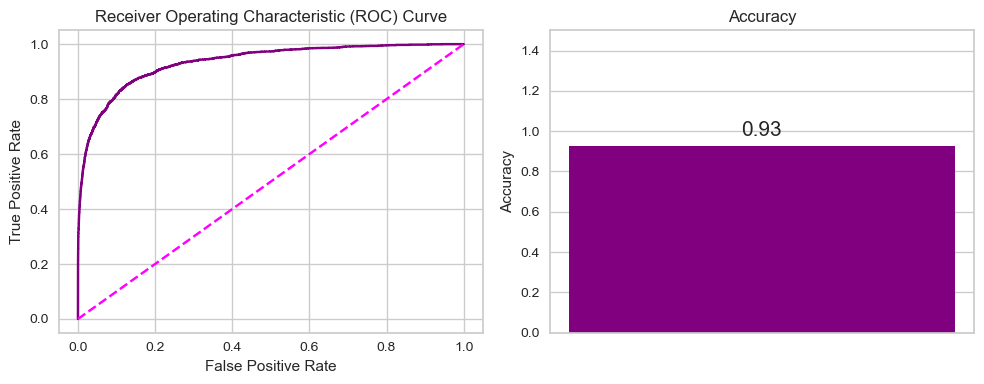

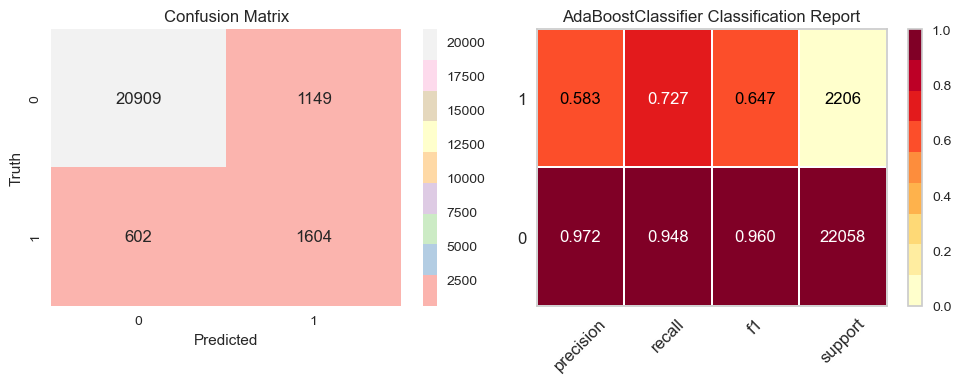

CPU times: total: 1min 15s
Wall time: 2min 32s


In [13]:
%%time
from sklearn.ensemble import AdaBoostClassifier
# define the parameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 1.0]}
# Create the AdaBoost model
adaboost_model = AdaBoostClassifier(random_state=42)

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)
experiment.train(adaboost_model,param_grid=param_grid,search_type='random')

In [14]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     22058
           1       0.58      0.73      0.65      2206

    accuracy                           0.93     24264
   macro avg       0.78      0.84      0.80     24264
weighted avg       0.94      0.93      0.93     24264

[[20909  1149]
 [  602  1604]]


In [15]:
saved_model_path = experiment.save_model('models/adaboost_base.pkl')
print("Model saved at:", saved_model_path)

Model saved at: models/adaboost_base.pkl


In [16]:
from catboost import CatBoostClassifier

# Define the CatBoost classifier
catboost_model = CatBoostClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'iterations': [500,600,700],  # Number of boosting iterations
    'depth': [3],               # Depth of the trees
    'learning_rate': [0.01, 0.1], # Learning rate
    'l2_leaf_reg': [3],             # L2 regularization coefficient
    'verbose':[0]
}

Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'verbose': 0, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 3}
Best estimator: <catboost.core.CatBoostClassifier object at 0x0000027B93486A00>
Best score: 0.9949014292704718
AUC: 0.9535146235667987
TPR:  80.36999999999999% 
FPR:  4.99% 
Threshold:  0.28
Predictive Equality:  58.4%


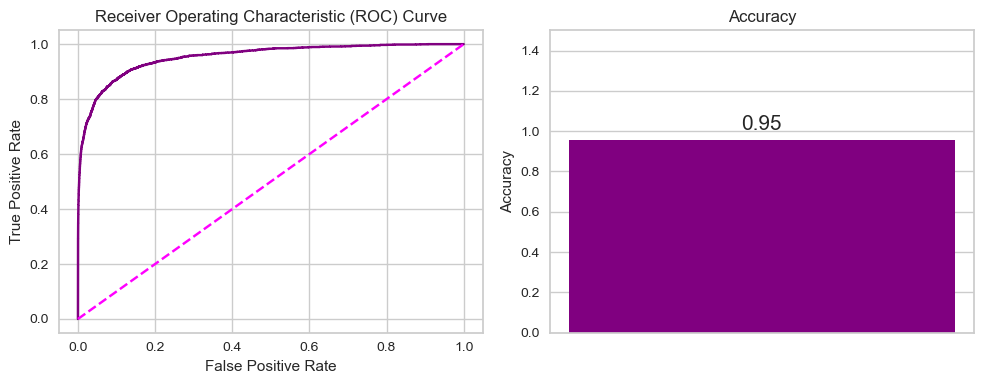

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     22058
           1       0.79      0.69      0.74      2206

    accuracy                           0.95     24264
   macro avg       0.88      0.84      0.86     24264
weighted avg       0.95      0.95      0.95     24264

CPU times: total: 9.75 s
Wall time: 38.1 s


In [17]:
%%time
experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups,name='catboost')
experiment.train(catboost_model,param_grid=param_grid,search_type='random')

In [18]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.28, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     22058
           1       0.62      0.80      0.70      2206

    accuracy                           0.94     24264
   macro avg       0.80      0.88      0.83     24264
weighted avg       0.95      0.94      0.94     24264

[[20974  1084]
 [  436  1770]]


In [19]:
saved_model_path = experiment.save_model('models/catboost_base.pkl')
print("Model saved at:", saved_model_path)

Model saved at: models/catboost_base.pkl


# working on Variant 1

In [20]:
# reading the base csv file using the custom class
df=data_cleaning('Variant I.csv')

# reformate the features datatypes
df.data['income']= df.data['income'].astype(float)
df.data['customer_age']= df.data['customer_age'].astype(int)
df.data['email_is_free']=df.data['email_is_free'].astype(int)
df.data['phone_home_valid']=df.data['phone_home_valid'].astype(int)
df.data['phone_mobile_valid']=df.data['phone_mobile_valid'].astype(int)
df.data['has_other_cards']=df.data['has_other_cards'].astype(int)
df.data['foreign_request']=df.data['foreign_request'].astype(int)
df.data['keep_alive_session']=df.data['keep_alive_session'].astype(int)
df.data['source']=df.data['source'].astype('object')
df.data['device_distinct_emails_8w']=df.data['device_distinct_emails_8w'].astype(int)
# replace the -1 values with nulls
df.put_nulls()

prev_address_months_count 704367
current_address_months_count 4442
credit_risk_score 537
bank_months_count 254905
session_length_in_minutes 1842
device_distinct_emails_8w 318


fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           704367
current_address_months_count          4442
customer_age                             0
days_since_request                       0
intended_balcon_amount                   0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                      537
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   254905
has_other_cards                          0
proposed_cr

In [21]:
# handling the intended balcon 
# replace negative values with np.nan in column 'A'
df.data['intended_balcon_amount'] = df.data['intended_balcon_amount'].mask(df.data['intended_balcon_amount'] < 0, np.nan)
df.data.isna().sum()

fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           704367
current_address_months_count          4442
customer_age                             0
days_since_request                       0
intended_balcon_amount              739988
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                      537
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   254905
has_other_cards                          0
proposed_cr

In [22]:
# handling the nulls
df.delete_columns(['prev_address_months_count','intended_balcon_amount'])
df.data['current_address_months_count'].fillna(df.data.current_address_months_count.mode()[0],inplace=True)
df.data['credit_risk_score'].fillna(df.data.credit_risk_score.mean(),inplace=True)
df.data['bank_months_count'].fillna(df.data.bank_months_count.mode()[0],inplace=True)
df.data['session_length_in_minutes'].fillna(df.data.session_length_in_minutes.mean(),inplace=True)
df.data['device_distinct_emails_8w'].fillna(df.data.device_distinct_emails_8w.mode()[0],inplace=True)
df.data.isna().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
current_address_months_count        0
customer_age                        0
days_since_request                  0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_length_in_minutes           0
device_os                           0
keep_alive_s

In [23]:
data=df.get_data()
X = data.drop(['fraud_bool'], axis=1)
y = data['fraud_bool']
# to use near miss we have to preprocess the data first so we will encode the features only first
data = preprocessing(X, y)

# define dictionary with key name of the column and value the label encoder fitted on the training set in the preprocessing class
encoders = {}
for column in X.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder
X,y=data.get_data()

# manually remove the last columns created from one hot encoding as (pd.get_dummies(keep_first=false))
cols=[ 'name_email_similarity', 
       'current_address_months_count',  'days_since_request',
 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       
       'bank_months_count', 'proposed_credit_limit',
        'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w','payment_type_AB',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
        'employment_status_CB', 'employment_status_CC',
       'employment_status_CD', 'employment_status_CE', 'employment_status_CF',
       'employment_status_CG', 'housing_status_BB',
       'housing_status_BC', 'housing_status_BD', 'housing_status_BE',
       'housing_status_BF', 'housing_status_BG', 
       'source_TELEAPP',  'device_os_macintosh',
       'device_os_other', 'device_os_windows', 'device_os_x11',
     'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards','foreign_request','income','customer_age','month']
X=X[cols]


nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_nm, y_nm = nm.fit_resample(X, y)
data=pd.concat([X_nm, y_nm],axis=1)
# split the data using stratifying
X_train, X_test, y_train, y_test=split_data(data,criteria= 'stratify')

# forming the groups to test fairness
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

data=preprocessing(X_train,y_train)

# define a dictionary with the key is the name of the column and the value is the scaler object which is returned from the method
# in the preprocessing class.
scalers = {} 
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('minmax',column)
    scalers[column] = scaler
    
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])
    
X_train,y_train=data.get_data()


# over sample the minority class in the train data

categorical_columns_indices = [i for i in range(13,43)] 

smote_nc = SMOTENC(categorical_features=categorical_columns_indices, random_state=42)

X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)
# define modeling instance to start the experiment the modeling instance takes the data and the groups.
experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)

# training both the adaboost and catboost

Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'n_estimators': 200, 'learning_rate': 1.0}
Best estimator: AdaBoostClassifier(n_estimators=200, random_state=42)
Best score: 0.9876474919645775
AUC: 0.9323920568102539
TPR:  69.63000000000001% 
FPR:  4.9799999999999995% 
Threshold:  0.5
Predictive Equality:  100.0%


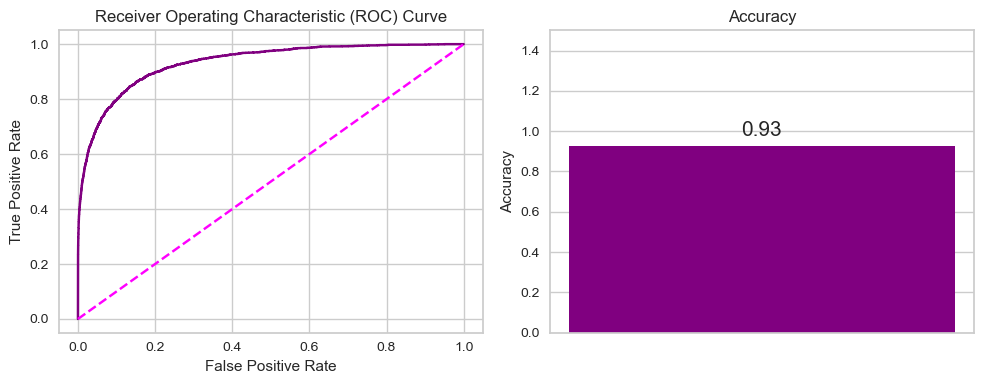

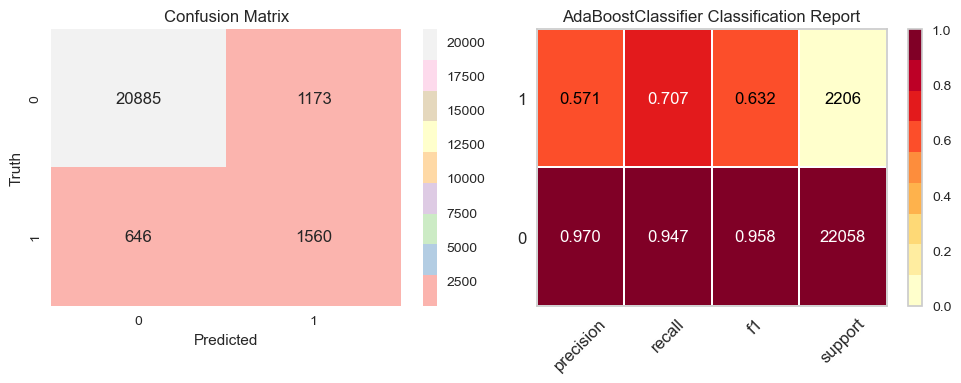

CPU times: total: 1min 15s
Wall time: 2min 30s


In [24]:
%%time
from sklearn.ensemble import AdaBoostClassifier
# define the parameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 1.0]}
# Create the AdaBoost model
adaboost_model = AdaBoostClassifier(random_state=42)

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)
experiment.train(adaboost_model,param_grid=param_grid,search_type='random')

In [25]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     22058
           1       0.57      0.71      0.63      2206

    accuracy                           0.93     24264
   macro avg       0.77      0.83      0.79     24264
weighted avg       0.93      0.93      0.93     24264

[[20885  1173]
 [  646  1560]]


In [26]:
saved_model_path = experiment.save_model('models/adaboost_variant_1.pkl')
print("Model saved at:", saved_model_path)

Model saved at: models/adaboost_variant_1.pkl


Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'verbose': 0, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 3}
Best estimator: <catboost.core.CatBoostClassifier object at 0x0000027B935780A0>
Best score: 0.9944711119627383
AUC: 0.9537890587141606
TPR:  77.88000000000001% 
FPR:  4.99% 
Threshold:  0.27
Predictive Equality:  98.03%


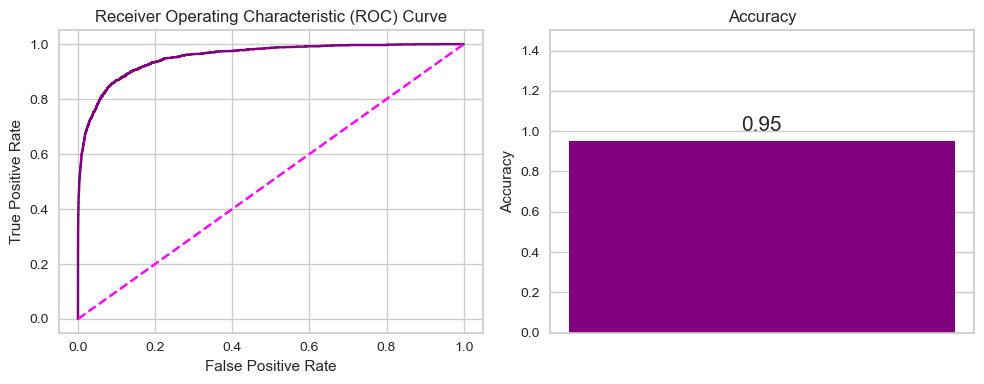

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     22058
           1       0.79      0.66      0.72      2206

    accuracy                           0.95     24264
   macro avg       0.88      0.82      0.85     24264
weighted avg       0.95      0.95      0.95     24264

CPU times: total: 9.95 s
Wall time: 51.3 s


In [29]:
%%time
# Define the CatBoost classifier
catboost_model = CatBoostClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'iterations': [500,600,700],  # Number of boosting iterations
    'depth': [3],               # Depth of the trees
    'learning_rate': [0.01, 0.1], # Learning rate
    'l2_leaf_reg': [3],             # L2 regularization coefficient
    'verbose':[0]
}

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups,name='catboost')
experiment.train(catboost_model,param_grid=param_grid,search_type='random')

In [30]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.27, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     22058
           1       0.61      0.78      0.68      2206

    accuracy                           0.93     24264
   macro avg       0.79      0.87      0.82     24264
weighted avg       0.94      0.93      0.94     24264

[[20950  1108]
 [  484  1722]]


In [31]:
saved_model_path = experiment.save_model('models/catboost_variant_1.pkl')
print("Model saved at:", saved_model_path)

Model saved at: models/catboost_variant_1.pkl


# working on variant 2

In [32]:
# reading the base csv file using the custom class
df=data_cleaning('Variant II.csv')

# reformate the features datatypes
df.data['income']= df.data['income'].astype(float)
df.data['customer_age']= df.data['customer_age'].astype(int)
df.data['email_is_free']=df.data['email_is_free'].astype(int)
df.data['phone_home_valid']=df.data['phone_home_valid'].astype(int)
df.data['phone_mobile_valid']=df.data['phone_mobile_valid'].astype(int)
df.data['has_other_cards']=df.data['has_other_cards'].astype(int)
df.data['foreign_request']=df.data['foreign_request'].astype(int)
df.data['keep_alive_session']=df.data['keep_alive_session'].astype(int)
df.data['source']=df.data['source'].astype('object')
df.data['device_distinct_emails_8w']=df.data['device_distinct_emails_8w'].astype(int)
# replace the -1 values with nulls
df.put_nulls()

prev_address_months_count 759415
current_address_months_count 3488
credit_risk_score 435
bank_months_count 241872
session_length_in_minutes 2277
device_distinct_emails_8w 336


fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           759415
current_address_months_count          3488
customer_age                             0
days_since_request                       0
intended_balcon_amount                   0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                      435
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   241872
has_other_cards                          0
proposed_cr

In [33]:
# handling the intended balcon 
# replace negative values with np.nan in column 'A'
df.data['intended_balcon_amount'] = df.data['intended_balcon_amount'].mask(df.data['intended_balcon_amount'] < 0, np.nan)
df.data.isna().sum()

fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           759415
current_address_months_count          3488
customer_age                             0
days_since_request                       0
intended_balcon_amount              749184
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                      435
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   241872
has_other_cards                          0
proposed_cr

In [34]:
# handling the nulls
df.delete_columns(['prev_address_months_count','intended_balcon_amount'])
df.data['current_address_months_count'].fillna(df.data.current_address_months_count.mode()[0],inplace=True)
df.data['credit_risk_score'].fillna(df.data.credit_risk_score.mean(),inplace=True)
df.data['bank_months_count'].fillna(df.data.bank_months_count.mode()[0],inplace=True)
df.data['session_length_in_minutes'].fillna(df.data.session_length_in_minutes.mean(),inplace=True)
df.data['device_distinct_emails_8w'].fillna(df.data.device_distinct_emails_8w.mode()[0],inplace=True)

data=df.get_data()
X = data.drop(['fraud_bool'], axis=1)
y = data['fraud_bool']
# to use near miss we have to preprocess the data first so we will encode the features only first
data = preprocessing(X, y)

# define dictionary with key name of the column and value the label encoder fitted on the training set in the preprocessing class
encoders = {}
for column in X.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder
X,y=data.get_data()

# manually remove the last columns created from one hot encoding as (pd.get_dummies(keep_first=false))
cols=[ 'name_email_similarity', 
       'current_address_months_count',  'days_since_request',
 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       
       'bank_months_count', 'proposed_credit_limit',
        'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w','payment_type_AB',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
        'employment_status_CB', 'employment_status_CC',
       'employment_status_CD', 'employment_status_CE', 'employment_status_CF',
       'employment_status_CG', 'housing_status_BB',
       'housing_status_BC', 'housing_status_BD', 'housing_status_BE',
       'housing_status_BF', 'housing_status_BG', 
       'source_TELEAPP',  'device_os_macintosh',
       'device_os_other', 'device_os_windows', 'device_os_x11',
     'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards','foreign_request','income','customer_age','month']
X=X[cols]


nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_nm, y_nm = nm.fit_resample(X, y)
data=pd.concat([X_nm, y_nm],axis=1)
# split the data using stratifying
X_train, X_test, y_train, y_test=split_data(data,criteria= 'stratify')

# forming the groups to test fairness
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

data=preprocessing(X_train,y_train)

# define a dictionary with the key is the name of the column and the value is the scaler object which is returned from the method
# in the preprocessing class.
scalers = {} 
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('minmax',column)
    scalers[column] = scaler
    
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])
    
X_train,y_train=data.get_data()


# over sample the minority class in the train data

categorical_columns_indices = [i for i in range(13,43)] 

smote_nc = SMOTENC(categorical_features=categorical_columns_indices, random_state=42)

X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)
# define modeling instance to start the experiment the modeling instance takes the data and the groups.
experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)


# training and evaluating the models

Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'n_estimators': 200, 'learning_rate': 1.0}
Best estimator: AdaBoostClassifier(n_estimators=200, random_state=42)
Best score: 0.9904196470031869
AUC: 0.9377659117103864
TPR:  71.21% 
FPR:  5.0% 
Threshold:  0.5
Predictive Equality:  100.0%


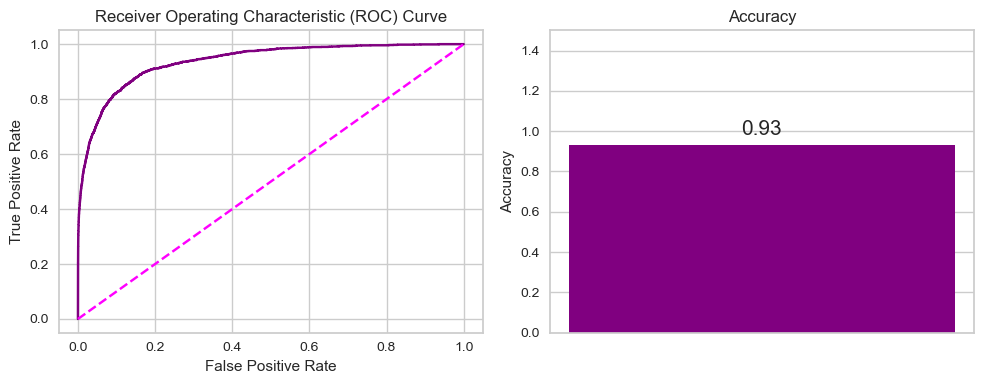

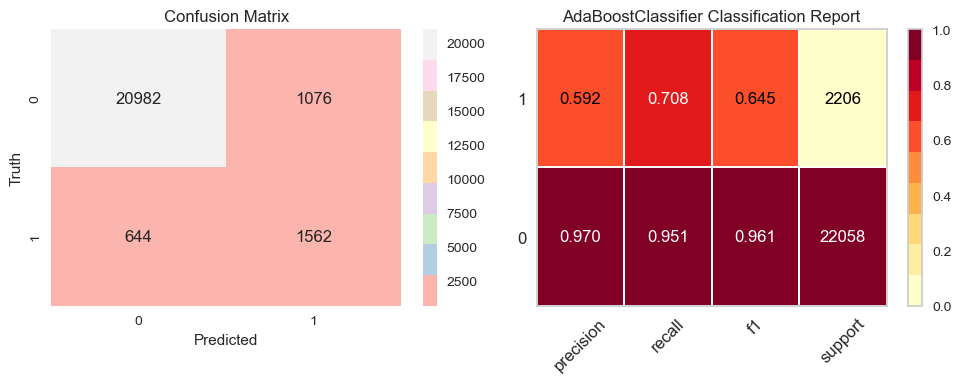

CPU times: total: 1min 15s
Wall time: 2min 28s


In [35]:
%%time
from sklearn.ensemble import AdaBoostClassifier
# define the parameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 1.0]}
# Create the AdaBoost model
adaboost_model = AdaBoostClassifier(random_state=42)

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)
experiment.train(adaboost_model,param_grid=param_grid,search_type='random')

In [36]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))
saved_model_path = experiment.save_model('models/adaboost_variant_2.pkl')
print("Model saved at:", saved_model_path)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     22058
           1       0.59      0.71      0.64      2206

    accuracy                           0.93     24264
   macro avg       0.78      0.83      0.80     24264
weighted avg       0.94      0.93      0.93     24264

[[20982  1076]
 [  644  1562]]
Model saved at: models/adaboost_variant_2.pkl


Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'verbose': 0, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 3}
Best estimator: <catboost.core.CatBoostClassifier object at 0x0000027B8589D220>
Best score: 0.9952168488477834
AUC: 0.9548633508609585
TPR:  79.36999999999999% 
FPR:  4.99% 
Threshold:  0.28
Predictive Equality:  55.36%


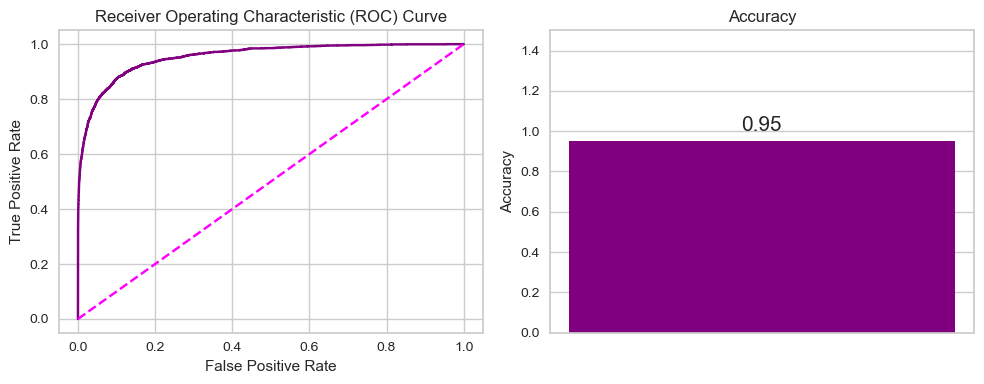

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     22058
           1       0.76      0.69      0.72      2206

    accuracy                           0.95     24264
   macro avg       0.87      0.83      0.85     24264
weighted avg       0.95      0.95      0.95     24264

CPU times: total: 10.2 s
Wall time: 49.8 s


In [37]:
%%time
# Define the CatBoost classifier
catboost_model = CatBoostClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'iterations': [500,600,700],  # Number of boosting iterations
    'depth': [3],               # Depth of the trees
    'learning_rate': [0.01, 0.1], # Learning rate
    'l2_leaf_reg': [3],             # L2 regularization coefficient
    'verbose':[0]
}

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups,name='catboost')
experiment.train(catboost_model,param_grid=param_grid,search_type='random')

In [38]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.28, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))
saved_model_path = experiment.save_model('models/catboost_variant_2.pkl')
print("Model saved at:", saved_model_path)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     22058
           1       0.61      0.80      0.69      2206

    accuracy                           0.94     24264
   macro avg       0.80      0.87      0.83     24264
weighted avg       0.95      0.94      0.94     24264

[[20943  1115]
 [  452  1754]]
Model saved at: models/catboost_variant_2.pkl


# working on variant 3:

In [47]:
# reading the base csv file using the custom class
df=data_cleaning('Variant III.csv')

# reformate the features datatypes
df.data['income']= df.data['income'].astype(float)
df.data['customer_age']= df.data['customer_age'].astype(int)
df.data['email_is_free']=df.data['email_is_free'].astype(int)
df.data['phone_home_valid']=df.data['phone_home_valid'].astype(int)
df.data['phone_mobile_valid']=df.data['phone_mobile_valid'].astype(int)
df.data['has_other_cards']=df.data['has_other_cards'].astype(int)
df.data['foreign_request']=df.data['foreign_request'].astype(int)
df.data['keep_alive_session']=df.data['keep_alive_session'].astype(int)
df.data['source']=df.data['source'].astype('object')
df.data['device_distinct_emails_8w']=df.data['device_distinct_emails_8w'].astype(int)
# replace the -1 values with nulls
df.put_nulls()

prev_address_months_count 762005
current_address_months_count 3473
credit_risk_score 402
bank_months_count 247242
session_length_in_minutes 2256
device_distinct_emails_8w 332


fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           762005
current_address_months_count          3473
customer_age                             0
days_since_request                       0
intended_balcon_amount                   0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                      402
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   247242
has_other_cards                          0
proposed_cr

In [48]:
# handling the intended balcon 
# replace negative values with np.nan in column 'A'
df.data['intended_balcon_amount'] = df.data['intended_balcon_amount'].mask(df.data['intended_balcon_amount'] < 0, np.nan)
# handling the nulls
df.delete_columns(['prev_address_months_count','intended_balcon_amount'])
df.data['current_address_months_count'].fillna(df.data.current_address_months_count.mode()[0],inplace=True)
df.data['credit_risk_score'].fillna(df.data.credit_risk_score.mean(),inplace=True)
df.data['bank_months_count'].fillna(df.data.bank_months_count.mode()[0],inplace=True)
df.data['session_length_in_minutes'].fillna(df.data.session_length_in_minutes.mean(),inplace=True)
df.data['device_distinct_emails_8w'].fillna(df.data.device_distinct_emails_8w.mode()[0],inplace=True)

data=df.get_data()
X = data.drop(['fraud_bool'], axis=1)
y = data['fraud_bool']
# to use near miss we have to preprocess the data first so we will encode the features only first
data = preprocessing(X, y)

# define dictionary with key name of the column and value the label encoder fitted on the training set in the preprocessing class
encoders = {}
for column in X.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder
X,y=data.get_data()

# manually remove the last columns created from one hot encoding as (pd.get_dummies(keep_first=false))
cols=[ 'name_email_similarity', 
       'current_address_months_count',  'days_since_request',
 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       
       'bank_months_count', 'proposed_credit_limit',
        'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w','payment_type_AB',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
        'employment_status_CB', 'employment_status_CC',
       'employment_status_CD', 'employment_status_CE', 'employment_status_CF',
       'employment_status_CG', 'housing_status_BB',
       'housing_status_BC', 'housing_status_BD', 'housing_status_BE',
       'housing_status_BF', 'housing_status_BG', 
       'source_TELEAPP',  'device_os_macintosh',
       'device_os_other', 'device_os_windows', 'device_os_x11',
     'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards','foreign_request','income','customer_age','month']
X=X[cols]


nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_nm, y_nm = nm.fit_resample(X, y)
data=pd.concat([X_nm, y_nm],axis=1)
# split the data using stratifying
X_train, X_test, y_train, y_test=split_data(data,criteria= 'stratify')

# forming the groups to test fairness
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

data=preprocessing(X_train,y_train)

# define a dictionary with the key is the name of the column and the value is the scaler object which is returned from the method
# in the preprocessing class.
scalers = {} 
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('minmax',column)
    scalers[column] = scaler
    
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])
    
X_train,y_train=data.get_data()


# over sample the minority class in the train data

categorical_columns_indices = [i for i in range(13,43)] 

smote_nc = SMOTENC(categorical_features=categorical_columns_indices, random_state=42)

X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)
# define modeling instance to start the experiment the modeling instance takes the data and the groups.
experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)


Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'n_estimators': 200, 'learning_rate': 1.0}
Best estimator: AdaBoostClassifier(n_estimators=200, random_state=42)
Best score: 0.9889334332979113
AUC: 0.9329265606287641
TPR:  70.67% 
FPR:  4.97% 
Threshold:  0.5
Predictive Equality:  100.0%


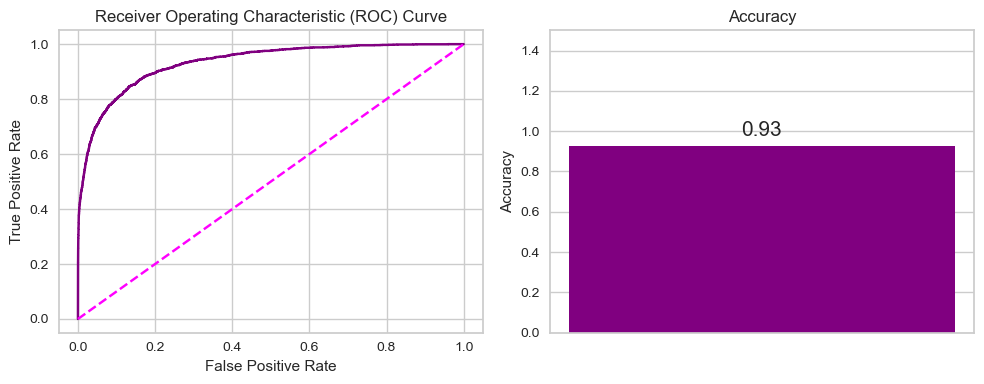

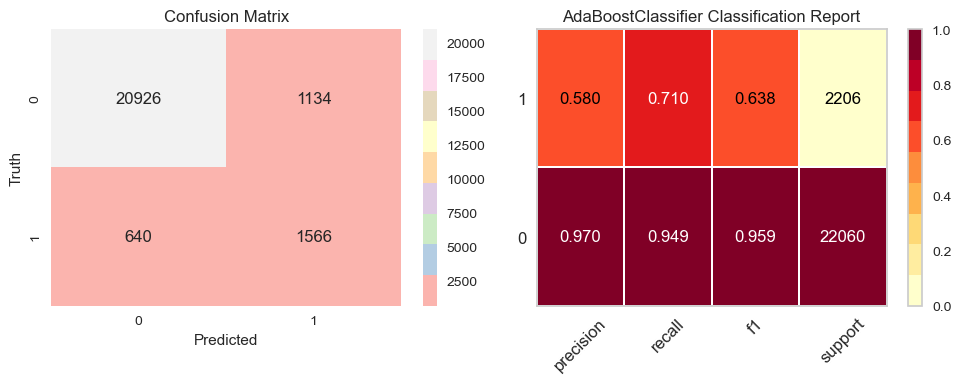

CPU times: total: 1min 20s
Wall time: 2min 42s


In [49]:
%%time
from sklearn.ensemble import AdaBoostClassifier
# define the parameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 1.0]}
# Create the AdaBoost model
adaboost_model = AdaBoostClassifier(random_state=42)

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)
experiment.train(adaboost_model,param_grid=param_grid,search_type='random')

In [50]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))
saved_model_path = experiment.save_model('models/adaboost_variant_3.pkl')
print("Model saved at:", saved_model_path)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     22060
           1       0.58      0.71      0.64      2206

    accuracy                           0.93     24266
   macro avg       0.78      0.83      0.80     24266
weighted avg       0.93      0.93      0.93     24266

[[20926  1134]
 [  640  1566]]
Model saved at: models/adaboost_variant_3.pkl


Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'verbose': 0, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 3}
Best estimator: <catboost.core.CatBoostClassifier object at 0x0000027B88ECA250>
Best score: 0.9947547397392732
AUC: 0.9534403822427749
TPR:  78.47% 
FPR:  4.97% 
Threshold:  0.27
Predictive Equality:  92.92%


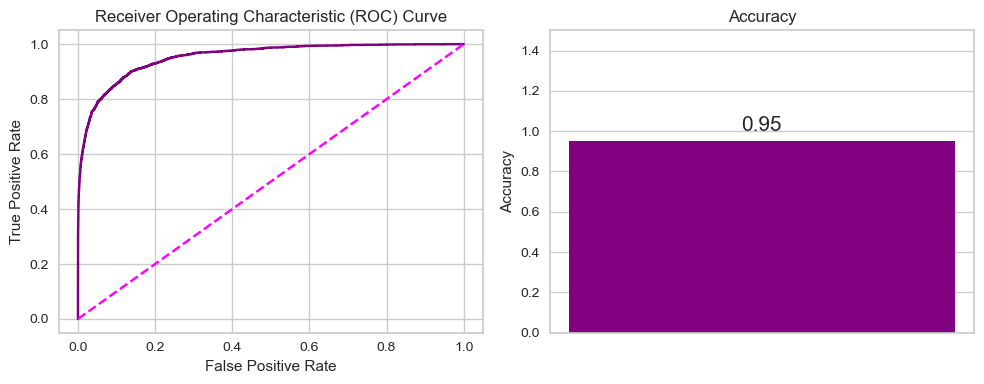

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     22060
           1       0.78      0.66      0.72      2206

    accuracy                           0.95     24266
   macro avg       0.87      0.82      0.85     24266
weighted avg       0.95      0.95      0.95     24266

CPU times: total: 9.19 s
Wall time: 1min 5s


In [51]:
%%time
# Define the CatBoost classifier
catboost_model = CatBoostClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'iterations': [500,600,700],  # Number of boosting iterations
    'depth': [3],               # Depth of the trees
    'learning_rate': [0.01, 0.1], # Learning rate
    'l2_leaf_reg': [3],             # L2 regularization coefficient
    'verbose':[0]
}

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups,name='catboost')
experiment.train(catboost_model,param_grid=param_grid,search_type='random')

In [52]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.27, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))
saved_model_path = experiment.save_model('models/catboost_variant_3.pkl')
print("Model saved at:", saved_model_path)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     22060
           1       0.61      0.78      0.69      2206

    accuracy                           0.94     24266
   macro avg       0.79      0.87      0.83     24266
weighted avg       0.94      0.94      0.94     24266

[[20961  1099]
 [  475  1731]]
Model saved at: models/catboost_variant_2.pkl


# working on variant 4:

In [53]:
# reading the base csv file using the custom class
df=data_cleaning('Variant IV.csv')

# reformate the features datatypes
df.data['income']= df.data['income'].astype(float)
df.data['customer_age']= df.data['customer_age'].astype(int)
df.data['email_is_free']=df.data['email_is_free'].astype(int)
df.data['phone_home_valid']=df.data['phone_home_valid'].astype(int)
df.data['phone_mobile_valid']=df.data['phone_mobile_valid'].astype(int)
df.data['has_other_cards']=df.data['has_other_cards'].astype(int)
df.data['foreign_request']=df.data['foreign_request'].astype(int)
df.data['keep_alive_session']=df.data['keep_alive_session'].astype(int)
df.data['source']=df.data['source'].astype('object')
df.data['device_distinct_emails_8w']=df.data['device_distinct_emails_8w'].astype(int)
# replace the -1 values with nulls
df.put_nulls()


prev_address_months_count 761771
current_address_months_count 3479
credit_risk_score 399
bank_months_count 247181
session_length_in_minutes 2262
device_distinct_emails_8w 334


fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           761771
current_address_months_count          3479
customer_age                             0
days_since_request                       0
intended_balcon_amount                   0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                      399
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   247181
has_other_cards                          0
proposed_cr

In [54]:
# handling the intended balcon 
# replace negative values with np.nan in column 'A'
df.data['intended_balcon_amount'] = df.data['intended_balcon_amount'].mask(df.data['intended_balcon_amount'] < 0, np.nan)
# handling the nulls
df.delete_columns(['prev_address_months_count','intended_balcon_amount'])
df.data['current_address_months_count'].fillna(df.data.current_address_months_count.mode()[0],inplace=True)
df.data['credit_risk_score'].fillna(df.data.credit_risk_score.mean(),inplace=True)
df.data['bank_months_count'].fillna(df.data.bank_months_count.mode()[0],inplace=True)
df.data['session_length_in_minutes'].fillna(df.data.session_length_in_minutes.mean(),inplace=True)
df.data['device_distinct_emails_8w'].fillna(df.data.device_distinct_emails_8w.mode()[0],inplace=True)

data=df.get_data()
X = data.drop(['fraud_bool'], axis=1)
y = data['fraud_bool']
# to use near miss we have to preprocess the data first so we will encode the features only first
data = preprocessing(X, y)

# define dictionary with key name of the column and value the label encoder fitted on the training set in the preprocessing class
encoders = {}
for column in X.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder
X,y=data.get_data()

# manually remove the last columns created from one hot encoding as (pd.get_dummies(keep_first=false))
cols=[ 'name_email_similarity', 
       'current_address_months_count',  'days_since_request',
 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       
       'bank_months_count', 'proposed_credit_limit',
        'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w','payment_type_AB',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
        'employment_status_CB', 'employment_status_CC',
       'employment_status_CD', 'employment_status_CE', 'employment_status_CF',
       'employment_status_CG', 'housing_status_BB',
       'housing_status_BC', 'housing_status_BD', 'housing_status_BE',
       'housing_status_BF', 'housing_status_BG', 
       'source_TELEAPP',  'device_os_macintosh',
       'device_os_other', 'device_os_windows', 'device_os_x11',
     'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards','foreign_request','income','customer_age','month']
X=X[cols]


nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_nm, y_nm = nm.fit_resample(X, y)
data=pd.concat([X_nm, y_nm],axis=1)
# split the data using stratifying
X_train, X_test, y_train, y_test=split_data(data,criteria= 'stratify')

# forming the groups to test fairness
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

data=preprocessing(X_train,y_train)

# define a dictionary with the key is the name of the column and the value is the scaler object which is returned from the method
# in the preprocessing class.
scalers = {} 
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('minmax',column)
    scalers[column] = scaler
    
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])
    
X_train,y_train=data.get_data()


# over sample the minority class in the train data

categorical_columns_indices = [i for i in range(13,43)] 

smote_nc = SMOTENC(categorical_features=categorical_columns_indices, random_state=42)

X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)
# define modeling instance to start the experiment the modeling instance takes the data and the groups.
experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)


# training the models:

Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'n_estimators': 200, 'learning_rate': 1.0}
Best estimator: AdaBoostClassifier(n_estimators=200, random_state=42)
Best score: 0.9896647167785949
AUC: 0.9383295084945122
TPR:  72.21% 
FPR:  4.99% 
Threshold:  0.5
Predictive Equality:  100.0%


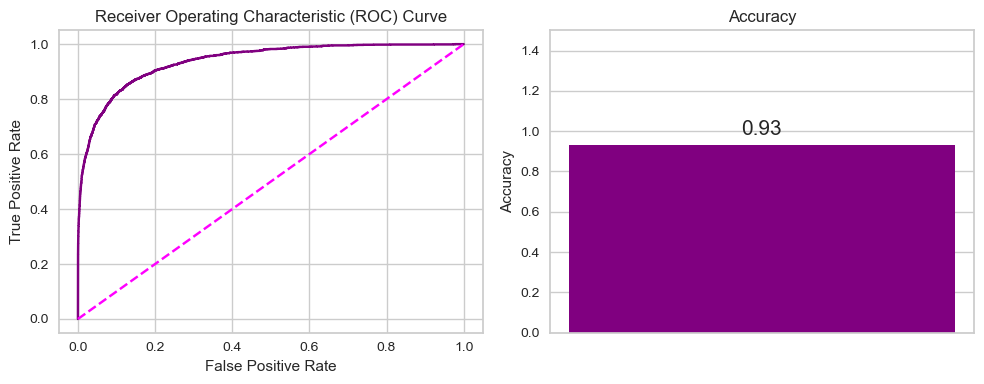

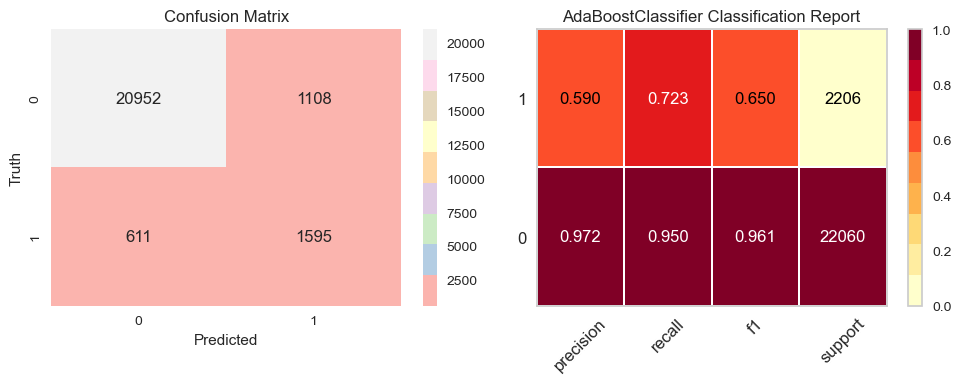

CPU times: total: 1min 13s
Wall time: 2min 44s


In [55]:
%%time
from sklearn.ensemble import AdaBoostClassifier
# define the parameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 1.0]}
# Create the AdaBoost model
adaboost_model = AdaBoostClassifier(random_state=42)

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)
experiment.train(adaboost_model,param_grid=param_grid,search_type='random')

In [56]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))
saved_model_path = experiment.save_model('models/adaboost_variant_4.pkl')
print("Model saved at:", saved_model_path)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     22060
           1       0.59      0.72      0.65      2206

    accuracy                           0.93     24266
   macro avg       0.78      0.84      0.81     24266
weighted avg       0.94      0.93      0.93     24266

[[20952  1108]
 [  611  1595]]
Model saved at: models/adaboost_variant_4.pkl


Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'verbose': 0, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 3}
Best estimator: <catboost.core.CatBoostClassifier object at 0x0000027B8BE77E20>
Best score: 0.9952789315212031
AUC: 0.9561092142175506
TPR:  80.05% 
FPR:  4.97% 
Threshold:  0.27
Predictive Equality:  63.029999999999994%


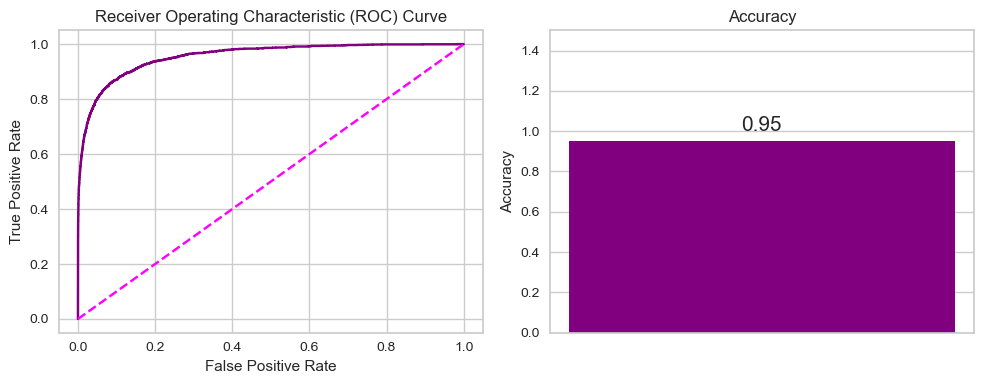

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     22060
           1       0.78      0.68      0.73      2206

    accuracy                           0.95     24266
   macro avg       0.87      0.83      0.85     24266
weighted avg       0.95      0.95      0.95     24266

CPU times: total: 9.03 s
Wall time: 52.8 s


In [57]:
%%time
# Define the CatBoost classifier
catboost_model = CatBoostClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'iterations': [500,600,700],  # Number of boosting iterations
    'depth': [3],               # Depth of the trees
    'learning_rate': [0.01, 0.1], # Learning rate
    'l2_leaf_reg': [3],             # L2 regularization coefficient
    'verbose':[0]
}

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups,name='catboost')
experiment.train(catboost_model,param_grid=param_grid,search_type='random')

In [58]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.27, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))
saved_model_path = experiment.save_model('models/catboost_variant_4.pkl')
print("Model saved at:", saved_model_path)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     22060
           1       0.61      0.80      0.70      2206

    accuracy                           0.94     24266
   macro avg       0.80      0.88      0.83     24266
weighted avg       0.95      0.94      0.94     24266

[[20945  1115]
 [  435  1771]]
Model saved at: models/catboost_variant_4.pkl


# working on variant 5:

In [59]:
# reading the base csv file using the custom class
df=data_cleaning('Variant V.csv')

# reformate the features datatypes
df.data['income']= df.data['income'].astype(float)
df.data['customer_age']= df.data['customer_age'].astype(int)
df.data['email_is_free']=df.data['email_is_free'].astype(int)
df.data['phone_home_valid']=df.data['phone_home_valid'].astype(int)
df.data['phone_mobile_valid']=df.data['phone_mobile_valid'].astype(int)
df.data['has_other_cards']=df.data['has_other_cards'].astype(int)
df.data['foreign_request']=df.data['foreign_request'].astype(int)
df.data['keep_alive_session']=df.data['keep_alive_session'].astype(int)
df.data['source']=df.data['source'].astype('object')
df.data['device_distinct_emails_8w']=df.data['device_distinct_emails_8w'].astype(int)
# replace the -1 values with nulls
df.put_nulls()


prev_address_months_count 761730
current_address_months_count 3381
credit_risk_score 397
bank_months_count 246922
session_length_in_minutes 2165
device_distinct_emails_8w 342


fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           761730
current_address_months_count          3381
customer_age                             0
days_since_request                       0
intended_balcon_amount                   0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                      397
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   246922
has_other_cards                          0
proposed_cr

In [60]:
# handling the intended balcon 
# replace negative values with np.nan in column 'A'
df.data['intended_balcon_amount'] = df.data['intended_balcon_amount'].mask(df.data['intended_balcon_amount'] < 0, np.nan)
# handling the nulls
df.delete_columns(['prev_address_months_count','intended_balcon_amount'])
df.data['current_address_months_count'].fillna(df.data.current_address_months_count.mode()[0],inplace=True)
df.data['credit_risk_score'].fillna(df.data.credit_risk_score.mean(),inplace=True)
df.data['bank_months_count'].fillna(df.data.bank_months_count.mode()[0],inplace=True)
df.data['session_length_in_minutes'].fillna(df.data.session_length_in_minutes.mean(),inplace=True)
df.data['device_distinct_emails_8w'].fillna(df.data.device_distinct_emails_8w.mode()[0],inplace=True)

data=df.get_data()
X = data.drop(['fraud_bool'], axis=1)
y = data['fraud_bool']
# to use near miss we have to preprocess the data first so we will encode the features only first
data = preprocessing(X, y)

# define dictionary with key name of the column and value the label encoder fitted on the training set in the preprocessing class
encoders = {}
for column in X.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder
X,y=data.get_data()

# manually remove the last columns created from one hot encoding as (pd.get_dummies(keep_first=false))
cols=[ 'name_email_similarity', 
       'current_address_months_count',  'days_since_request',
 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       
       'bank_months_count', 'proposed_credit_limit',
        'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w','payment_type_AB',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
        'employment_status_CB', 'employment_status_CC',
       'employment_status_CD', 'employment_status_CE', 'employment_status_CF',
       'employment_status_CG', 'housing_status_BB',
       'housing_status_BC', 'housing_status_BD', 'housing_status_BE',
       'housing_status_BF', 'housing_status_BG', 
       'source_TELEAPP',  'device_os_macintosh',
       'device_os_other', 'device_os_windows', 'device_os_x11',
     'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards','foreign_request','income','customer_age','month']
X=X[cols]


nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_nm, y_nm = nm.fit_resample(X, y)
data=pd.concat([X_nm, y_nm],axis=1)
# split the data using stratifying
X_train, X_test, y_train, y_test=split_data(data,criteria= 'stratify')

# forming the groups to test fairness
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

data=preprocessing(X_train,y_train)

# define a dictionary with the key is the name of the column and the value is the scaler object which is returned from the method
# in the preprocessing class.
scalers = {} 
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('minmax',column)
    scalers[column] = scaler
    
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])
    
X_train,y_train=data.get_data()


# over sample the minority class in the train data

categorical_columns_indices = [i for i in range(13,43)] 

smote_nc = SMOTENC(categorical_features=categorical_columns_indices, random_state=42)

X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)
# define modeling instance to start the experiment the modeling instance takes the data and the groups.
experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)


# Training the models:

Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'n_estimators': 200, 'learning_rate': 1.0}
Best estimator: AdaBoostClassifier(n_estimators=200, random_state=42)
Best score: 0.9880007958157181
AUC: 0.9309621867009038
TPR:  69.58% 
FPR:  4.9799999999999995% 
Threshold:  0.5
Predictive Equality:  100.0%


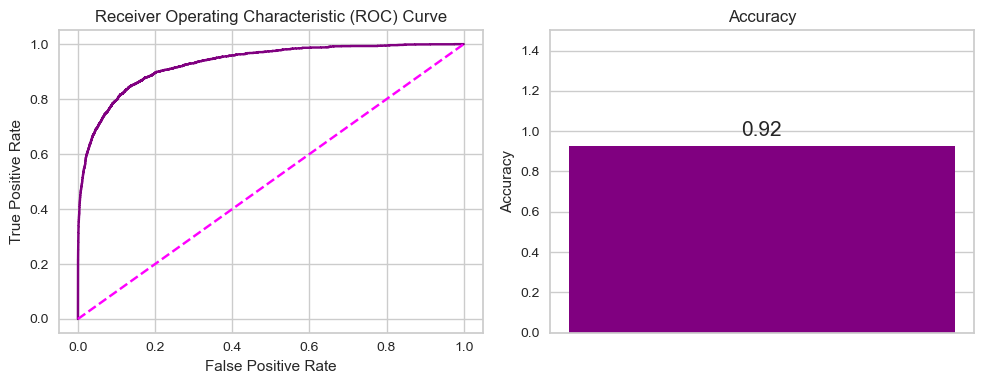

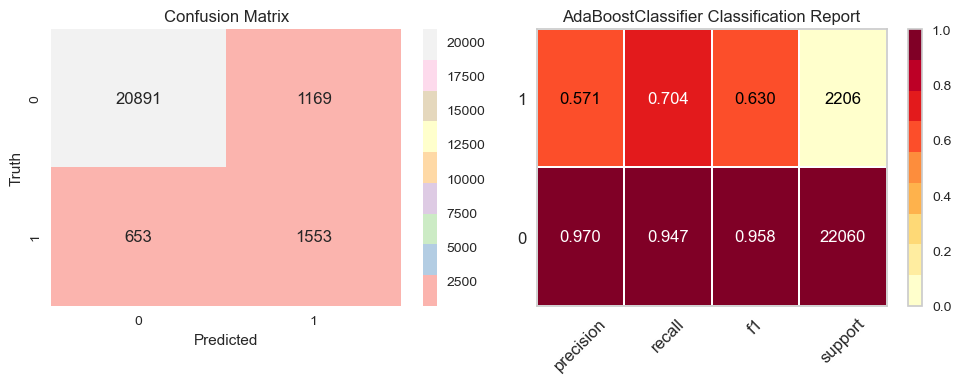

CPU times: total: 1min 29s
Wall time: 2min 56s


In [61]:
%%time
from sklearn.ensemble import AdaBoostClassifier
# define the parameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 1.0]}
# Create the AdaBoost model
adaboost_model = AdaBoostClassifier(random_state=42)

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups)
experiment.train(adaboost_model,param_grid=param_grid,search_type='random')

In [62]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))
saved_model_path = experiment.save_model('models/adaboost_variant_5.pkl')
print("Model saved at:", saved_model_path)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     22060
           1       0.57      0.70      0.63      2206

    accuracy                           0.92     24266
   macro avg       0.77      0.83      0.79     24266
weighted avg       0.93      0.92      0.93     24266

[[20891  1169]
 [  653  1553]]
Model saved at: models/adaboost_variant_5.pkl


Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best hyperparameters: {'verbose': 0, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 3}
Best estimator: <catboost.core.CatBoostClassifier object at 0x0000027B8C52FE20>
Best score: 0.9947781785696476
AUC: 0.9520440420874743
TPR:  78.14999999999999% 
FPR:  4.99% 
Threshold:  0.27
Predictive Equality:  87.26%


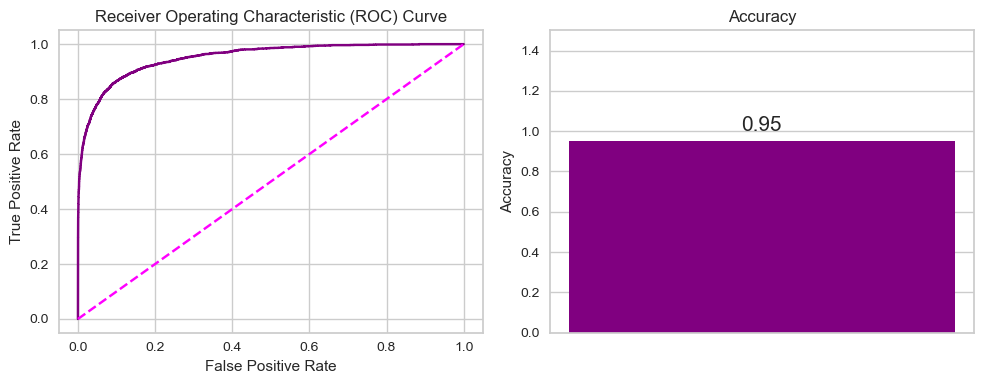

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     22060
           1       0.79      0.66      0.72      2206

    accuracy                           0.95     24266
   macro avg       0.88      0.82      0.85     24266
weighted avg       0.95      0.95      0.95     24266

CPU times: total: 9.86 s
Wall time: 55.9 s


In [63]:
%%time
# Define the CatBoost classifier
catboost_model = CatBoostClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'iterations': [500,600,700],  # Number of boosting iterations
    'depth': [3],               # Depth of the trees
    'learning_rate': [0.01, 0.1], # Learning rate
    'l2_leaf_reg': [3],             # L2 regularization coefficient
    'verbose':[0]
}

experiment=modeling(X_train_res,X_test,y_train_res,y_test,train_groups,test_groups,name='catboost')
experiment.train(catboost_model,param_grid=param_grid,search_type='random')

In [64]:
# the classification report after using the best threshold
y_pred=experiment.best.predict_proba(X_test)[:,1]
y_pred_new_threshold = np.where(y_pred >= 0.27, 1, 0)
print(classification_report(y_test,y_pred_new_threshold))
print(confusion_matrix(y_test,y_pred_new_threshold))
saved_model_path = experiment.save_model('models/catboost_variant_5.pkl')
print("Model saved at:", saved_model_path)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     22060
           1       0.61      0.78      0.68      2206

    accuracy                           0.93     24266
   macro avg       0.79      0.87      0.82     24266
weighted avg       0.94      0.93      0.94     24266

[[20949  1111]
 [  481  1725]]
Model saved at: models/catboost_variant_5.pkl


# final comments:
- as we can see this pipeline could reach to the nearly the same results over the five variants of the dataset.
- adaboost always could give 100% perdictive equality but with ranging auc from [0.930 to 0.938].
- while the catboost always achieve higher AUC but lower predictive equality.
- its auc ranges from [0.950 to 0.955].
- while it always get bad predictive equality except for variant 1 (0.98) as this variant has higher group disparsity than the base and variant 3 (0.92) as this variant has better seperabitility than the base.